# Imports

In [62]:
# importing required libraries
import pandas as pd
import numpy as np
import category_encoders as ce
import matplotlib.pyplot as plt
import re
from datetime import datetime as dt
import calendar as cl
from scipy.stats import pearsonr
import random
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar

# ML
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from patsy import dmatrices
import statsmodels.api as sm
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt, SARIMAX

# Notebook settings
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

from IPython.display import Markdown, display
def printmd(string):
    display(Markdown(string))
 
# Silence chained warnings
pd.options.mode.chained_assignment = None
import logging
loggers = [logging.getLogger(name) for name in logging.root.manager.loggerDict]
for logger in loggers:
    logger.setLevel(logging.CRITICAL)
import warnings
warnings.filterwarnings("ignore")

# Read Data

In [157]:
# Read in data
temp = pd.read_csv('/Users/mfairb/Documents/ML Projects/Project - Pythonic Time Series/Milestone 1 Dataset/hr_temp_20170201-20200131_subset.csv')
ft = pd.read_csv('/Users/mfairb/Documents/ML Projects/Project - Pythonic Time Series/Milestone 1 Dataset/hr_temp_20200201-20200229_subset.csv')
meter = pd.read_csv('/Users/mfairb/Documents/ML Projects/Project - Pythonic Time Series/Milestone 1 Dataset/hrl_load_metered - 20170201-20200131.csv')

# Keep only needed columns in temp and meter
temp = temp[['DATE', 'HourlyDryBulbTemperature']]
meter = meter[['datetime_beginning_ept', 'mw']]

# Cleaning

In [158]:
# Adjust column names
temp = temp.rename(columns={'DATE':'date'})
meter = meter.rename(columns={'datetime_beginning_ept':'b_ept'})
ft = ft.rename(columns={'DATE':'date'})

# Standardize time format between sets (using format from temp)
temp['date'] = pd.to_datetime(temp['date'])
ft['date'] = pd.to_datetime(ft['date'])
meter['b_ept'] = pd.to_datetime(meter['b_ept'])

# Sort and join on index
temp = temp.sort_values(by='date')
ft = ft.sort_values(by='date')
meter = meter.sort_values(by='b_ept')

# Creating Train vs. Test

In [159]:
# Join on date (date & b_ept)
data = {'mw': meter['mw'], 
        'temp': temp['HourlyDryBulbTemperature'], 
        'date': temp['date']}

ft_data = {'temp': ft['HourlyDryBulbTemperature'], 
           'date': ft['date']}

df = pd.DataFrame(data)
ft = pd.DataFrame(ft_data)

df['date'] = pd.to_datetime(df['date'])
ft['date'] = pd.to_datetime(ft['date'])

# Create hour, day, month, year columns
new_columns = ['hour', 'day', 'month', 'year']
for c in new_columns:
   df[c] = [eval(f't.{c}') for t in df.date]
   ft[c] = [eval(f't.{c}') for t in ft.date]
   
df['weekday'] = [t.weekday() for t in df.date]
ft['weekday'] = [t.weekday() for t in ft.date]

# Adjust columns and set index
df = df.rename(columns={'HourlyDryBulbTemperature':'temp'})
df = df.set_index('date')

ft = ft.set_index('date')

# Interpolating (Note that calling interp1d with NaNs present in input values results in undefined behaviour)
df['temp'] = df['temp'].interpolate(method='linear')

# Create train & test
train = df[df.year < 2020]
test = df[df.year >= 2020]

# Visualization

###### Auxillary functions/definitions

In [ ]:
# FUNCTION: Plot any time period
def plot_timeblock(df, 
                   variable=None,
                   timeblock=None,
                   years=[2017, 2018, 2019, 2020],
                   months=range(1, 13),
                   weeks=range(1, 53),
                   days=range(1, 32),
                   weekdays=range(1, 8)
                  ):
    
    df = df[(df.index.year.isin(years)) & \
               (df.index.month.isin(months)) & \
               (df.index.week.isin(weeks)) & \
               (df.index.day.isin(days)) & \
               (df.index.weekday.isin(weekdays))]

    df_timeblock = f'df.{timeblock}'

    for t in pd.unique(eval(df_timeblock)):
        plt.plot(eval(f'df.{variable}[{df_timeblock}=={t}]'))
        
    plt.title(variable)
    plt.xticks(rotation=45)
    plt.show()

In [ ]:
# FUNCTION: Create data frame for any time period
def create_timeblock(df, 
                   variable=None,
                   timeblock=None,
                   years=[2017, 2018, 2019, 2020],
                   months=range(1, 13),
                   weeks=range(1, 53),
                   days=range(1, 32),
                   weekdays=range(1, 8)
                  ):
    
    df = df[(df.index.year.isin(years)) & \
               (df.index.month.isin(months)) & \
               (df.index.week.isin(weeks)) & \
               (df.index.day.isin(days)) & \
               (df.index.weekday.isin(weekdays))]

    return(df)

In [ ]:
# FUNCTION: Overlay temp and mw for same time period
def plot_overlay(data1, data2, title):
    
    # Create some plot
    fig, ax1 = plt.subplots()
    
    color = 'tab:red'
    ax1.set_xlabel('time (hr)')
    ax1.set_ylabel('temp', color=color)
    ax1.plot(data1, color=color)
    ax1.tick_params(axis='y', labelcolor=color)
    
    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
    
    color = 'tab:blue'
    ax2.set_ylabel('mw', color=color)
    ax2.plot(data2, color=color)
    ax2.tick_params(axis='y', labelcolor=color)
    
    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    fig.autofmt_xdate()
    plt.title(title.upper())
    plt.show();

In [ ]:
# FUNCTION: Robust plot_overlay
def robust_plot_overlay(data, title):
    
    # Create some mock data
    fig, axes = plt.subplots()
    
    for d in data:

In [ ]:
# Create season ranges
year = 2017
spring_range = pd.date_range(f'{year}-03-01', f'{year}-05-31')
summer_range = pd.date_range(f'{year}-06-01', f'{year}-08-31')
fall_range = pd.date_range(f'{year}-09-01', f'{year}-11-30')
winter_range = pd.date_range(f'{year}-12-01', f'{year+1}-02-28')

###### 1. Plot the training energy data over time.<br>

In [ ]:
# Training ENERGY data over time
plot_timeblock(train,
              variable='mw',
              timeblock='year',
              years=[2017, 2018, 2019])

###### 2. Dive deeper and plot one week of the training energy data.<br>

In [ ]:
# Plot several weeks from each season to view daily energy use
n_cols = 2
n_rows = 2
seasons = ['spring', 'summer', 'fall', 'winter']

for season in seasons:
    printmd(f'**{season.upper()} DAILY PLOTS**')
    fig, ax = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(15, 10))
    fig.tight_layout()
    #fig.autofmt_xdate()
    
    axs = ax.flatten()
    for axes in axs:
        dt = random.choice(eval(f'{season}_range'))
        block = create_timeblock(train,
                                 variable='temp',
                                 timeblock='week',
                                 years=[dt.year],
                                 weeks=[dt.week])
        
        for tick in axes.get_xticklabels():
            tick.set_rotation(10)

        _ = axes.plot(block.temp);
        
    plt.show();

 Day of the week observations:
 <br><br>
 Spring: Fairly stable energy use on a day-over-day basis though some larger peaks/valleys do appear
 <br><br>
 Summer: High daily peaks while the maximum energy expended per day seems to slightly decrease towards the middle of the week before again increasing at the end of the week
 <br><br>
 Fall: Earlier fall months resemble summer patterns while later fall months are more difficult to describe. There seems to be more variation on a daily basis in colder months than in warmer.
 <br><br>
 Winter: More erratic energy behavior though in later winter month there does seem to be more weeks that start with medium/high energy and then taper off towards the end of the week

In [ ]:
# Plot several days from each season to view hourly energy use
n_rows = 1
n_cols = 3
seasons = ['spring', 'summer', 'fall', 'winter']

for season in seasons:
    printmd(f'**{season.upper()} DAILY PLOTS**')
    fig, ax = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(15, 5))
    fig.tight_layout()
    axs = ax.flatten()
    
    months = pd.unique([d.month for d in eval(f'{season}_range')])
    
    for i in range(len(axs)):
        dt = random.choice(eval(f'{season}_range[{season}_range.month==months[i]]'))
        block = create_timeblock(train,
                                 variable='temp',
                                 timeblock='year',
                                 years=[dt.year],
                                 weeks=[dt.week],
                                 weekdays=[1])
        
        for tick in axs[i].get_xticklabels():
            tick.set_rotation(30)
            
        _ = axs[i].plot(block.temp);
        
    plt.show();

Hourly observations:
<br><br>
Spring: Earlierr spring days resumble winter days with a choppy peark that tapers off at the end of the day. Later spring days resemble the smooth S-curve seen in summer months.
<br><br>
Summer: Generally smooth S-curve
<br><br>
Fall: Shift from a smooth S-curve to a daily peak with sharp increase/decrease
<br><br>
Winter: Broken S-curve. Sometimes bimodal, other times with a plateau or very slight increase through midday. Most days end with sharp tapering off.

###### 3. Plot the training temperature data over time.

In [ ]:
# Plot temperature and energy overlay
plot_overlay(train.temp, train.mw, 'Temp & Energy Over Time')

###### 4. Dive deeper and plot one week of the training temperature data.

In [ ]:
# Training ENERGY day of the week (plot 10 random weeks)
seasons = ['spring', 'summer', 'fall', 'winter']
for season in seasons:
    dt = random.choice(eval(f'{season}_range'))
    a = create_timeblock(train,
                      variable='temp',
                      timeblock='year',
                      years=[dt.year],
                      weeks=[dt.week],
                      weekdays=[1])
    plot_overlay(a.temp, a.mw, season);


General observations:
<br><br>
In spring and summer months, temperature and energy seem to be very closely correlated. The shapes of the temperature and energy curves are often nearly identical.
<br><br>
In fall months, the two curves are still closely related but the relationship is a little choppier and deviations are more common.
<br><br>
In winter months, the two curves are more loosely correlated. Different than the daily curves other seasons, there is often a dip in energy use in the early evening followed by a secondary peak before tapering off at the end of the day. 

###### 5.Calculate the correlation of training energy data with your training temperature data.

In [ ]:
# Create function for optimal correlation split
# The temperature/energy relationship is non-linear but would like correlation split by temperature
span =  np.linspace(min(train.temp), max(train.temp), 50)[1:]
corrs = []
for c in span:
    try:
        x = train.temp[train.temp<c]
        y = train.mw[train.temp<c]
        corrs.append(pearsonr(x, y)[0])
    except:
        pass

optimal_split = span[np.argmin(corrs)]

under_x = train.temp[train.temp<optimal_split]
under_y = train.mw[train.temp<optimal_split]
over_x = train.temp[train.temp>=optimal_split]
over_y = train.mw[train.temp>=optimal_split]

neg_corr = round(pearsonr(under_x, under_y)[0], 2)
pos_corr = round(pearsonr(over_x, over_y)[0], 2)

plt.scatter(under_x, under_y)
plt.scatter(over_x, over_y)

plt.annotate(f'Negative Correlation: {neg_corr}', xy =(35, 1500), 
                xytext =(-8, 1000), arrowprops = dict(facecolor ='green', 
                                  shrink = 0.05))
plt.annotate(f'Positive Correlation: {pos_corr}', xy =(77, 2000), 
                xytext =(35, 2700), arrowprops = dict(facecolor ='green', 
                                  shrink = 0.05))
plt.title('Temperature vs. Energy Correlation')
plt.xlabel('Temp')
plt.ylabel('Energy')
plt.show();

###### 6.Plot a scatter plot between training temperature and energy data.

In [ ]:
plt.scatter(train.temp, train.mw)
plt.title('Temperature vs. Energy')
plt.xlabel('Temperature (f)')
plt.ylabel('Energy (mw)')
plt.show();

# Naive Model

###### Auxillary functions

In [66]:
# FUNCTION: Prepare df
def prep_data(df=None):
    """
    This function prepares a data set for modeling (or scoring) by:
        1) Creating a quadratic temperature variable based on a scaled version of temperature
        2) Converting categorical variables to dummy variables
        3) Building interaction effects if indicated
    """
    # Create X
    df2 = df.copy()
    
    # Standardize temp and temp2
    df2['temp'] = (df2['temp']-df2['temp'].mean())/df2['temp'].std()
    df2['temp2'] = df2['temp'] ** 2
    
    return(df2)

In [67]:
# FUNCTION: Model fitting
def model(fit_df, 
          pred_df=None,
          formula=None):
    
    model = sm.OLS.from_formula(formula, data=fit_df).fit()
    
    if pred_df is not None:
        preds = model.predict(pred_df)
        return model, preds
        
    else: 
        return model

In [68]:
# FUNCTION: Score model
def scoring(y_true, y_pred, method='mape'):
    
    # R2
    if method == 'r2':
        r2 = r2_score(y_true, y_pred)
        n = train.shape[0]
        p = train.shape[1]
        adj_r2 = 1-(1-r2)*(n-1)/(n-p-1)
        return adj_r2
    
    # MAPE
    elif method == 'mape':
        mape = round(np.mean(np.abs((y_true - y_pred) / y_true)) * 100, 4)
        return mape
    

In [164]:
# Create train and test for modeling/scoring
train = prep_data(train)
test = prep_data(test)
ft = prep_data(ft)

###### 2. Build an ordinary least squares (OLS) linear regression model on training data to predict energy using the variables described below.

In [10]:
# Create X & y
ols, preds = model(fit_df=train,
                   pred_df=train,
                   formula='mw ~ temp + temp2 + C(weekday) + C(hour) + C(month)')
r2 = scoring(preds, train.mw, method='r2')

print('Adjusted R^2 = ', round(r2, 4))

Adjusted R^2 =  0.809


###### 3. Plot the scatter plot between energy and temperature (as in the previous section), but only for the months of January and July.

In [ ]:
# Plot monthly scatter plots
for i in range(1,8):
    frame = train[train.month==i]
    plt.scatter(frame.temp, frame.mw)
    
plt.title('Temperature vs. Energy')
plt.xlabel('Temperature (f)')
plt.ylabel('Energy (mw)')
plt.show();


###### 4. Plot the scatter plot between energy and temperature (as in the previous section), but only for the hours of midnight and noon.

In [ ]:
# Plot monthly scatter plots
for i in [0, 12]:
    frame = train[train.hour==i]
    plt.scatter(frame.temp, frame.mw)
    
plt.title('Temperature vs. Energy')
plt.xlabel('Temperature (f)')
plt.ylabel('Energy (mw)')
plt.show();

###### 5. The relationship between energy and temperature depend on other factors, like hour of day and month of year. Add these two interactions to the linear regression model you previously built.

Treating hour of day, day of week, and month of year as categorical variables.<br>

In [11]:
# Model interactions
ols, preds = model(fit_df=train,
                   pred_df=train,
                   formula='mw ~ temp*C(hour) + temp2*C(hour) + temp*C(month) + temp2*C(month)')
r2 = scoring(preds, train.mw, method='r2')

print('Adjusted R^2 = ', round(r2, 4))

Adjusted R^2 =  0.8588


###### 6. Previously observed that the relationship between energy and hour of day changes depending on what day of the week it is. Add this new interaction to linear regression model and evaluate model.

###### 7. Calculate the predictions (or fitted values) from final linear regression model on training data set. Calculate the MAPE for these predictions from training data set.

In [70]:
# Model more interactions
ols, ols_train_preds = model(fit_df=train,
                   pred_df=train,
                   formula='mw ~ temp*C(hour) + temp2*C(hour) + temp*C(month) + temp2*C(month) + C(weekday)*C(hour)')
mape = scoring(ols_train_preds, train.mw)

print(f'Training MAPE = {mape}%')

Training MAPE = 3.5017%


###### 8. “Forecast” out your model by scoring your test data set with the linear regression you built. 

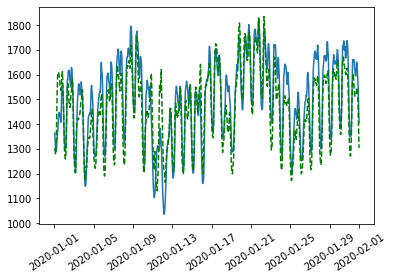

In [71]:
# Plot predicted vs. actual
ols, ols_test_preds = model(fit_df=train,
                   pred_df=test,
                   formula='mw ~ temp*C(hour) + temp2*C(hour) + temp*C(month) + temp2*C(month) + C(weekday)*C(hour)')

ols_test = pd.DataFrame()
ols_test['test_mw'] = test.mw
ols_test['test_preds'] = ols_test_preds

plt.plot(ols_test.test_mw)
plt.plot(ols_test.test_preds, 'g--')

plt.xticks(rotation=34)
plt.show();

# Time Series

###### 1. Save the residuals from first model on training data set as their own variable. Will build time series model on these residuals

###### 2. Visualize residuals across time in training data set.

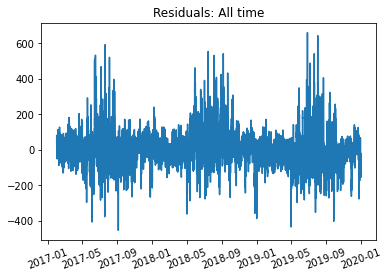

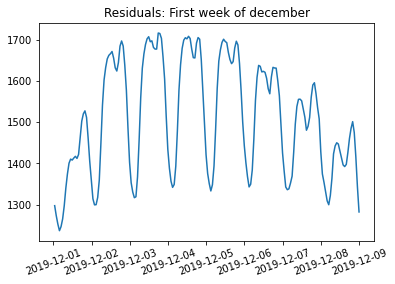

In [72]:
# Fit model and obtaining training predictions
ols, preds = model(fit_df=train,
                   pred_df=train,
                   formula='mw ~ temp*C(hour) + temp2*C(hour) + temp*C(month) + temp2*C(month) + C(weekday)*C(hour)')

# Create residuals
res = ols.resid

# Plot residuals
plt.plot(res)
plt.title('Residuals: All time')
plt.xticks(rotation=20)
plt.show();

plt.plot(preds['2019-12-01':'2019-12-08'])
plt.title('Residuals: First week of december')
plt.xticks(rotation=20)
plt.show();

###### 3. Build an Exponential Smoothing model on residuals that does not incorporate trend but does incorporate a 24-hour seasonal effect. Obtain predicted values of residuals on training data set from this model.
Add these predicted residuals to predictions of energy usage from your linear regression to obtain new dynamic model’s energy predictions.<br>
Calculate the training MAPE from these new predictions.<br>
Forecast out the next 744 hours of residuals (the month of January 2020).

In [73]:
# Holt Tuning Function
def tune_holt(smoothing_levels=None,
              smoothing_slopes=None,
              optimized=True):
    
    score_list = []
    
    for l in smoothing_levels:
        for s in smoothing_slopes:
            
            # Fit model, get fitted values, add to original predictions, score
            es = Holt(res).fit(smoothing_level=s, smoothing_slope=l, optimized=True)
            es_fitted_values = es.fittedvalues
            es_preds = preds + es_fitted_values
            es_mape = scoring(es_preds, train.mw)
            score_list.append([l, s, es_mape])
            
    scores = pd.DataFrame(score_list, columns=['Smoothing level', 'Smoothing slope', 'MAPE'])
    
    return scores


In [74]:
# Tune Exponential Smoothing Model
hold = tune_holt(np.linspace(0.00001,0.0001, 20),
                 np.linspace(0.00001,0.0001, 20),
                 optimized=True)

min_mape = np.argmin(hold.MAPE)
opt_s = hold['Smoothing slope'][min_mape]
opt_l = hold['Smoothing level'][min_mape]
holt = Holt(res).fit(smoothing_level=opt_s, smoothing_slope=opt_l, optimized=True)

# Get new train predictions
holt_preds = preds + holt.fittedvalues
holt_mape = scoring(holt_preds, train.mw)
print(f'Train Holt MAPE: {holt_mape}%')

# Get new test predictions
holt_fcst = holt.forecast(744)
holt_fcst.index = test.index
holt_test_preds = ols_test.test_preds + holt_fcst
scoring(test.mw, holt_test_preds)

KeyboardInterrupt: 

In [75]:
# Exponential esing with season effects
es = ExponentialSmoothing(res, seasonal_periods=24, seasonal='add', trend=None).fit()

es_fits = es.fittedvalues
es_preds = ols_train_preds + es_fits
es_mape = scoring(train.mw, es_preds)
print(f'Train ES MAPE: {es_mape}%')

# Forecast next 744 hours of residuals tog et new 01/2020 preds
es_fcst = es.forecast(744)
es_fcst.index = ols_test.index
es_test_fcst = ols_test.test_preds + es_fcst
es_test_mape = scoring(test.mw, es_test_fcst)
print(f'Test ES MAPE: {es_test_mape}%')

Train ES MAPE: 1.4963%
Test ES MAPE: 5.5003%


###### 4. Build a seasonal ARIMA model on the residuals that doesn’t incorporate trend but does incorporate a 24-hour seasonal effect.

Starting with two autoregressive terms, one seasonal difference, and one seasonal moving average term (ARIMA(2,0,0)(0,1,1)24)

In [76]:
# Fit SARIMA
sarima_mod = SARIMAX(res, order=(2,0,0), seasonal_order=(0,1,1,24))
sarima = sarima_mod.fit(disp=False)

In [77]:
# Get SARIMA predictions
sarima_preds = sarima.predict(start=pd.to_datetime(min(train.index)),
                              end=pd.to_datetime(max(train.index)), 
                              dynamic=False)

# Get new train preds and score
sarima_tr_preds = ols_train_preds + sarima_preds
sarima_tr_mape = scoring(sarima_tr_preds, train.mw)
print(f'Training SARIMA MAPE: {sarima_tr_mape}%')

# Forecast
sarima_fcst = sarima.forecast(744)
sarima_fcst.index = ols_test.index
sarima_te_preds = ols_test.test_preds + sarima_fcst
sarima_test_mape = scoring(test.mw, sarima_te_preds)
print(f'Test SARIMA MAPE: {sarima_test_mape}%')

Training SARIMA MAPE: 1.3726%
Test SARIMA MAPE: 5.5554%


###### 5. Ensemble your two residual forecasts from above to obtain a new residual forecast.

In [78]:
# Ensemble residual predictions, add to ols preds, and score
ens_res = (es_fits + sarima_preds)/2
ens_tr_pred = ols_train_preds + ens_res
ens_tr_mape = scoring(train.mw, ens_tr_pred)
print(f'Training Ensemble MAPE: {ens_tr_mape}%')

# Ensemble forecasts, add to ols forecast, and score
ens_fcst = (es_fcst + sarima_fcst)/2
ens_te_pred = ols_test.test_preds + ens_fcst
ens_te_mape = scoring(test.mw, ens_te_pred)
print(f'Test Ensemble MAPE: {ens_te_mape}%')

Training Ensemble MAPE: 1.3861%
Test Ensemble MAPE: 5.4973%


# Nuances

###### 1. Plot predicted energy usage as well as the actual energy usage for December 25, 2019.

Dec. 25th train MAPE: 1.8378%


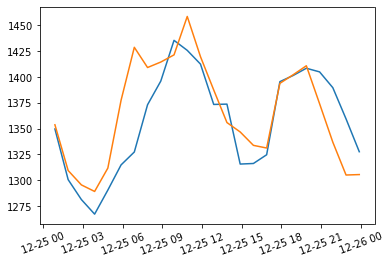

In [87]:
# Investigate Dec. 25th
dec_25_mape = scoring(train.mw['2019-12-25'], ens_tr_pred['2019-12-25'])
print(f'Dec. 25th train MAPE: {dec_25_mape}%')

plt.plot(train.mw['2019-12-25']);
plt.plot(ens_tr_pred['2019-12-25']);
plt.xticks(rotation=20);
plt.show();

###### 2. Create a holiday variable in training and test set that flags US federal holidays.

In [80]:
# FUNCTION: Add holiday indicators
def add_holiday_ind(df,
                    date_col=None,
                    use_index=True):
    
    df_new = df.copy()
    
    cal = calendar()
    if use_index:
        holidays = cal.holidays(start=df_new.index.min(), end=df_new.index.max()).strftime('%Y-%m-%d')
        df_new['holiday'] = df_new.index.strftime('%Y-%m-%d').isin(holidays)
    else:
        holidays = cal.holidays(start=df_new[date_col].min(), end=df_new[date_col].max()).strftime('%Y-%m-%d')
        df_new['holiday'] = df_new[date_col].strftime('%Y-%m-%d').isin(holidays)
        
    return df_new

In [167]:
# Add holiday indicators
train = add_holiday_ind(train)
test = add_holiday_ind(test)
ft = add_holiday_ind(ft)

###### 3. Repeat the process of the previous sections by creating a linear regression model, but with this new holiday variable added in as an additional predictor.

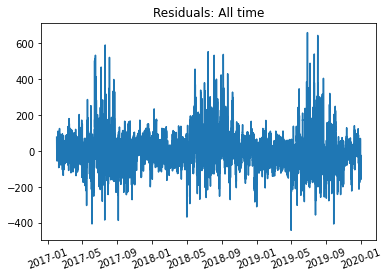

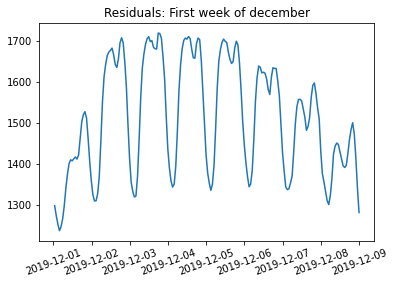

In [95]:
# Fit model and obtaining training predictions
ols, ols_tr_preds = model(fit_df=train,
                          pred_df=train,
                          formula='mw ~ temp*C(hour) + temp2*C(hour) + temp*C(month) + temp2*C(month) + C(weekday)*C(hour) + C(holiday)')

# Create residuals
res = ols.resid

# Plot residuals
plt.plot(res)
plt.title('Residuals: All time')
plt.xticks(rotation=20)
plt.show();

plt.plot(ols_tr_preds['2019-12-01':'2019-12-08'])
plt.title('Residuals: First week of december')
plt.xticks(rotation=20)
plt.show();

In [92]:
######--- Exponential smoothing with seasonal effects ---######
es = ExponentialSmoothing(res, seasonal_periods=24, seasonal='add', trend=None).fit()
es_fits = es.fittedvalues
es_preds = ols_train_preds + es_fits
es_mape = scoring(train.mw, es_preds)
print(f'Train ES MAPE: {es_mape}%')

# Forecast next 744 hours of residuals tog et new 01/2020 preds
es_fcst = es.forecast(744)
es_fcst.index = ols_test.index
es_test_fcst = ols_test.test_preds + es_fcst
es_test_mape = scoring(test.mw, es_test_fcst)
print(f'Test ES MAPE: {es_test_mape}%')

Train ES MAPE: 1.5819%
Test ES MAPE: 5.6657%


In [84]:
######--- Fit SARIMA ---######
sarima_mod = SARIMAX(res, order=(2,0,0), seasonal_order=(0,1,1,24))
sarima = sarima_mod.fit(disp=False)

# Get SARIMA predictions
sarima_preds = sarima.predict(start=pd.to_datetime(min(train.index)),
                              end=pd.to_datetime(max(train.index)), 
                              dynamic=False)

# Get new train preds and score
sarima_tr_preds = ols_train_preds + sarima_preds
sarima_tr_mape = scoring(sarima_tr_preds, train.mw)
print(f'Training SARIMA MAPE: {sarima_tr_mape}%')

# Forecast
sarima_fcst = sarima.forecast(744)
sarima_fcst.index = ols_test.index
sarima_te_preds = ols_test.test_preds + sarima_fcst
sarima_test_mape = scoring(test.mw, sarima_te_preds)
print(f'Test SARIMA MAPE: {sarima_test_mape}%')

Training SARIMA MAPE: 1.4715%
Test SARIMA MAPE: 5.4712%


In [100]:
# Ensemble residual predictions, add to ols preds, and score
ens_res = (es_fits + sarima_preds)/2
ens_tr_pred = ols_tr_preds + ens_res
ens_tr_mape = scoring(train.mw, ens_tr_pred)
print(f'Training Ensemble MAPE: {ens_tr_mape}%')

# Ensemble forecasts, add to ols forecast, and score
ens_fcst = (es_fcst + sarima_fcst)/2
ens_te_pred = ols_test.test_preds + ens_fcst
ens_te_mape = scoring(test.mw, ens_te_pred)
print(f'Test Ensemble MAPE: {ens_te_mape}%')

Training Ensemble MAPE: 1.3922%
Test Ensemble MAPE: 5.5365%


###### 4. Recreate previous plot but add a third line: your new forecasted energy usage for December 25, 2019, from your final holiday effects model.

Dec. 25th train MAPE: 1.9383%


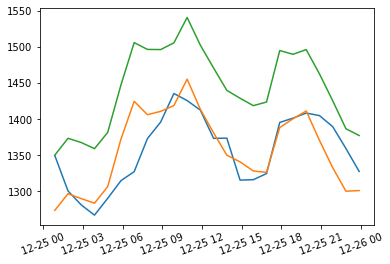

In [103]:
# Investigate Dec. 25th
dec_25_mape = scoring(train.mw['2019-12-25'], ens_tr_pred['2019-12-25'])
print(f'Dec. 25th train MAPE: {dec_25_mape}%')

plt.plot(train.mw['2019-12-25']);
plt.plot(ens_tr_pred['2019-12-25']);
plt.plot(sarima_tr_preds['2019-12-25']);
plt.xticks(rotation=20);
plt.show();

###### 5. Choose a final model from training MAPE of previous models.

In [104]:
# Ensemble forecasts, add to ols forecast, and score
ens_fcst = (es_fcst + sarima_fcst)/2
ens_te_pred = ols_test.test_preds + ens_fcst
ens_te_mape = scoring(test.mw, ens_te_pred)
print(f'Test Ensemble MAPE: {ens_te_mape}%')

Test Ensemble MAPE: 5.5365%


###### 6. Now that we have a final model, refit this final model on entire data set (training and testing combined).

In [193]:
# TO CREATE ENSEMBLE, FIT OLS, ES, SARIMA ON ENTIRE DATA SET
final_train = pd.concat([train, test])

# OLS
ols, ols_ft_preds = model(fit_df=final_train,
                          pred_df=ft,
                          formula='mw ~ temp*C(hour) + temp2*C(hour) + temp*C(month) + temp2*C(month) + C(weekday)*C(hour) + C(holiday)')
res = ols.resid

######----ES WITH SEASON----######
es = ExponentialSmoothing(res, seasonal_periods=24, seasonal='add', trend=None).fit()
es_fcst = es.forecast(696)
es_fcst.index = ft.index


# ######-------SARIMA-------######
#sarima_mod = SARIMAX(res, order=(2,0,0), seasonal_order=(0,1,1,24))
#sarima = sarima_mod.fit(disp=False)
sarima_fcst = sarima.forecast(696)
sarima_fcst.index = ft.index

# ######------ENSEMBLE-----######
ens_fcst = (es_fcst + sarima_fcst)/2
ens_ft_preds = ols_ft_preds + ens_fcst

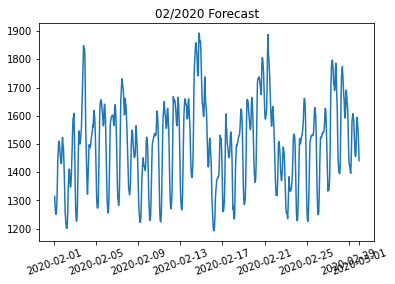

In [199]:
# View February forecast
plt.plot(ens_ft_preds)
plt.xticks(rotation=20)
plt.title('02/2020 Forecast')
plt.show();